<a href="https://colab.research.google.com/github/ahmedelsayed968/Machine-learning-Algorithms/blob/main/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


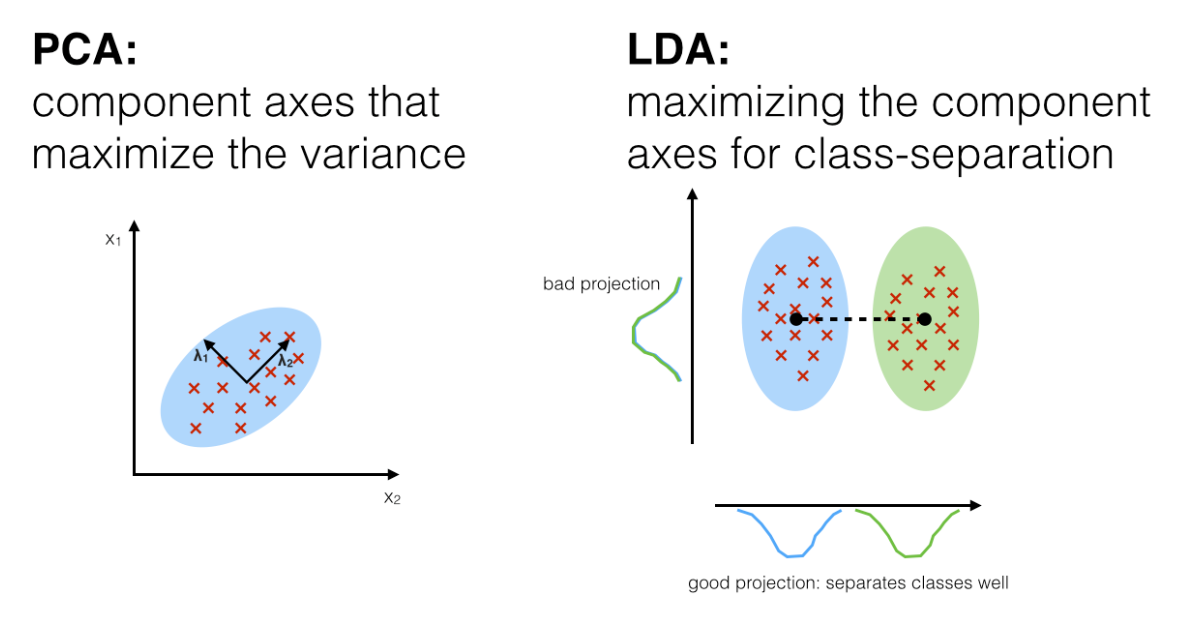

- our problem here is that:
  <br> 1. we want to Maximize the seperation between the classes by a hyperplane (this is why it's called Linear DA)
  <br> 2. we want to minimize the scatter in the intra-classes which coud be achieved using fisher's approach

## Fisher's Approach
Normalize the distance (difference between means by the intra-class Scatter (variance of each class )

Solution
First, some definitions:

Let:

n: be the number of classes<br>
μ:be the mean of all observations<br>
Ni:be the number of observations in the ith class<br>
μi:be the mean of the ith class<br>
ΣSc:be the scatter matrix of the c class<br>
1. **Now, define SW to be the within-class scatter matrix, given by**

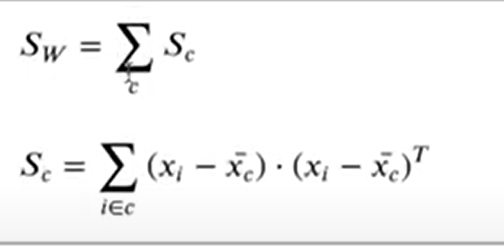

2. **and define SB to be the between-class scatter matrix, given by**

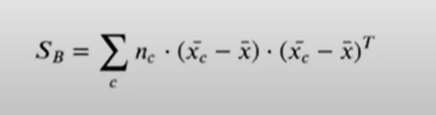

3. **Diagonalize inv(SW).SB
 to get its eigenvalues and eigenvectors.**

In [7]:
class LDA:
    def __init__(self,n_components):
      self.linear_discriminant = None
      self.n_components =n_components


    def __set_linear_discriminant(self,eigen_values,eigen_vectors):
      
      sorted_indices = np.argsort(eigen_values)[::-1]
      eigen_values   = eigen_values[sorted_indices]
      eigen_vectors  = eigen_vectors[sorted_indices]
      self.linear_discriminant = eigen_vectors[0:self.n_components,:]


    def fit_transform(self,X,y):
      """
      param: X input matrix in shape (n,m), y target labels (n,)
      return: linear_discriminant components
      """

      m_features = X.shape[1] 
      n_class = np.unique(y)

      # mean of all features columns 
      Total_mean = X.mean(axis=0)   # shape of (1,m)

      #initializing the matrices
      SW = np.zeros((m_features,m_features))
      SB = np.zeros((m_features,m_features))

      for class_ in n_class:
        # filler each class on the X
        x_c = X[y==class_]                        # shape of (n_c,m)
        # mean of each class
        x_c_mean = x_c.mean(axis=0)               # shape of (1,m)
        
        # compute Sc
        # (m_features,n_c).(n_c,m_features)
        Sc = (x_c-x_c_mean).T.dot((x_c-x_c_mean))
        SW = SW+Sc

        # num. of observation on each class
        nc = x_c.shape[0]
        
        # (n_c,m_features)-(1,m_features) --> broadcasting
        # (m_features,n_c).(n_c,m_features)
        diff = (x_c - Total_mean).T.dot((x_c - Total_mean))
        SB = SB + diff*nc

      # Diagonalize step
      # get inv(SW) . SB
      inv_SW = np.linalg.inv(SW)
      objective_W = inv_SW.dot(SB)

      # Diagonalize the objective function to get eigen_values and eigen vectors
      eigen_valus,eigen_vectors = np.linalg.eig(objective_W)
      self.__set_linear_discriminant(eigen_values=eigen_valus.T,
                                     eigen_vectors=eigen_vectors.T)
      
      return np.dot(X,self.linear_discriminant.T)






In [16]:
from sklearn import datasets
data_set = datasets.load_iris()
X = data_set.data
y = data_set.target
print(f'X before reduction : {X.shape}')
lda = LDA(n_components=2)
x_projected = lda.fit_transform(X,y)
print(f'X after projection : {x_projected.shape}')


X before reduction : (150, 4)
X after projection : (150, 2)


In [17]:
# x_projected

/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


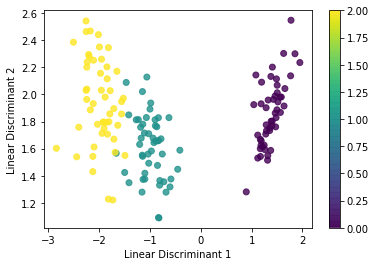

In [18]:
x1 = x_projected[:,0]
x2 = x_projected[:,1]
plt.scatter(
    x1,x2,
    c=y,
    alpha = 0.8
)
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.colorbar()
plt.show()

## LDA in Sklearn 

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA_ = LinearDiscriminantAnalysis(solver='eigen',shrinkage='auto')
x_projected_sk = LDA_.fit_transform(X,y)

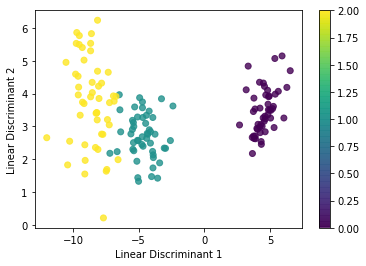

In [24]:
x1 = x_projected_sk[:,0]
x2 = x_projected_sk[:,1]
plt.scatter(
    x1,x2,
    c=y,
    alpha = 0.8
)
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.colorbar()
plt.show()

## Regularization (a.k.a. shrinkage)
  LDA can introduce overfitting. In essence, matrix inversion is an extremely sensitive operation (in that small changes in the matrix may lead to large changes in its inverse, so that even a tiny bit of noise will be amplified upon inverting the matrix), and so unless the estimate of the within-class scatter matrix SW
 is very good, its inversion is likely to introduce overfitting.

One way to combat that is through regularizing LDA. It basically replaces SW
 with (1−t)SW+tI
, where I
 is the identity matrix, and t
 is the regularization parameter, or the shrinkage constant. That’s what scikit’s shrinkage parameter is: it’s t
.